# 1.Sử dụng các checkpoint đã huấn luyện để đoán nhận dữ liệu

docs lib: https://keras.io/api/layers/recurrent_layers/lstm/

In [1]:
#@title Nhập tên các bộ dữ liệu đoán nhận
# là bộ dữ liệu hiện tại, được tạo trong lần đoán nhận này (tên file là lần đoán nhận này)
# sẽ trộn cả 2 bộ để đem ra đoán, nếu muốn đoán nhận từng bộ riêng lẻ thì comment lại bộ khác
# dùng model hiện tại để doán nhận bộ dữ liệu hiện tại => 2 bộ dưới là 2 bộ dữ liệu hiện tại
L_source = ",".join(map(lambda x: f"/cic/dataset/normalized_labeled/{x}/", [
    'nsm-2023w11-08-label',
    #'nsm-2023w09-01-label',
    #'nsm-2023w08-dos-01-label',
]))

In [2]:
#@title Nhập tên các checkpoint
# dòng đầu tiên, 2023W0702, là checkpoint hiện tại
# dòng thứ 2 trở đi, 2023W0701 ...., là các checkpoint quá khứ để đoán dữ liệu hiện tại là 2023W0702
# mỗi dòng, checkpoint là một model version được tải lên để đoán nhận các bộ dữ liệu L_source ở bên trên.
checkpoints = [
    '2023W1108',
    '2023W1107',
    '2023W1106',
    '2023W0904',
    #'2023W0703',
    #'2023W0702',
    #'2023W0701',
    #'2023W0604',
]

# 2.PREPARATION

In [3]:
#@title Check version vs GPU
!git --version
!python --version
!ray --version

import tensorflow as tf
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)

import sys
sys.version

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

git version 2.20.1
Python 2.7.16
ray, version 1.13.0
tf version:  2.7.0
tf.keras version: 2.7.0
Found GPU at: /device:GPU:0


2023-03-18 08:54:36.059620: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-18 08:54:38.163306: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-03-18 08:54:38.164943: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-03-18 08:54:38.166457: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capabilit

In [4]:
#@title Import Libraries
!mkdir -p /cic/images/

import sys
sys.path.insert(0, "/usr/local/opnsense/scripts/ml")

import json
import ray
import pandas as pd
from pandas import DataFrame

from ray.data import Dataset
from ray.data.aggregate import Count

import numpy as np
from tensorflow import keras

import common
from anomaly_normalization import LABEL
from aitests.testutils import show_scattered_4d, show_weights, show_4d_imgs, IMG, read_csv_in_dir

run, client = common.init_experiment(name='notebook')


2023-03-18 08:54:41,220[INFO][140351129294656-MainThread] worker.py:init(957) Connecting to existing Ray cluster at address: 172.18.12.180:6379
2023-03-18 08:54:43,270[INFO][140351129294656-MainThread] migration.py:__init__(204) Context impl PostgresqlImpl.
2023-03-18 08:54:43,272[INFO][140351129294656-MainThread] migration.py:__init__(211) Will assume transactional DDL.


# 3.INPUT
Let's generate a sample input with time dimension as below:

In [5]:
#@title Generate an input sequence
n_timesteps_in = 100  #@param {type:"integer"}
n_features = 79   #@param {type:"integer"}

L_data: Dataset = read_csv_in_dir(L_source)
L_count: DataFrame = L_data.groupby(LABEL).aggregate(Count()).to_pandas()

features = ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_min', 'pkt_len_std', 'pkt_len_var', 'pkt_size_avg', 'protocol', 'psh_flag_cnt', 'rst_flag_cnt', 'src_port', 'subflow_bwd_byts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_fwd_pkts', 'syn_flag_cnt', 'tot_bwd_pkts', 'tot_fwd_pkts', 'totlen_bwd_pkts', 'totlen_fwd_pkts', 'urg_flag_cnt']
features = features[0: n_features]
Lpadding_features = sorted(list(set(features) - set(L_data.schema(fetch_if_missing=True).names)))

total_size = int(L_count.sum()['count()']) // n_timesteps_in
predict_size = total_size
print ('features=', features)
print ('Lpadding_features=', Lpadding_features)
print ('total_size = ', total_size)
print ('predict_size = ', predict_size)


L_predict = DataFrame.from_records(L_data.take(predict_size  * n_timesteps_in))
L_predict[Lpadding_features] = 0
LX_predict = L_predict[features].to_numpy().reshape(predict_size, n_timesteps_in, n_features)
Ly_predict = L_predict[[LABEL]].to_numpy().reshape((predict_size, n_timesteps_in))

2023-03-18 08:54:47,938	WARNING read_api.py:256 -- The number of blocks in this dataset (15) limits its parallelism to 15 concurrent tasks. This is much less than the number of available CPU slots in the cluster. Use `.repartition(n)` to increase the number of dataset blocks.
Shuffle Reduce: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


features= ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pk

In [6]:
L_count

label  count()
0    0.0    45964
1    1.0    26935

## Data preview

### L_train preview

In [7]:
L_predict[[LABEL, *features]]

label  ack_flag_cnt  active_max  active_mean  active_min  active_std  \
0        0.0      1.000000         0.0          0.0         0.0         0.0   
1        0.0      0.964028         0.0          0.0         0.0         0.0   
2        0.0      0.964028         0.0          0.0         0.0         0.0   
3        0.0      0.995055         0.0          0.0         0.0         0.0   
4        0.0      0.964028         0.0          0.0         0.0         0.0   
...      ...           ...         ...          ...         ...         ...   
72795    1.0      1.000000         0.0          0.0         0.0         0.0   
72796    0.0      0.000000         0.0          0.0         0.0         0.0   
72797    0.0      0.000000         0.0          0.0         0.0         0.0   
72798    0.0      0.964028         0.0          0.0         0.0         0.0   
72799    0.0      0.000000         0.0          0.0         0.0         0.0   

       bwd_blk_rate_avg  bwd_byts_b_avg  bwd_header_len  bwd_iat_max  \
0                   1.0             1.0             1.0          1.0   
1                   0.0             0.0             0.0          0.0   
2                   0.0             0.0             0.0          0.0   
3                   0.0             0.0             1.0          1.0   
4                   0.0             0.0             0.0          0.0   
...                 ...             ...             ...          ...   
72795               0.0             0.0             1.0          1.0   
72796               0.0             0.0             1.0          1.0   
72797               0.0             0.0             1.0          1.0   
72798               0.0             0.0             1.0          0.0   
72799               1.0             1.0             1.0          1.0   

       bwd_iat_mean  bwd_iat_min  bwd_iat_std  bwd_iat_tot  bwd_pkt_len_max  \
0               1.0          1.0          1.0          1.0              1.0   
1               0.0          0.0          0.0          0.0              0.0   
2               0.0          0.0          0.0          0.0              0.0   
3               1.0          1.0          0.0          1.0              1.0   
4               0.0          0.0          0.0          0.0              0.0   
...             ...          ...          ...          ...              ...   
72795           1.0          1.0          1.0          1.0              1.0   
72796           1.0          1.0          1.0          1.0              1.0   
72797           1.0          1.0          1.0          1.0              1.0   
72798           0.0          0.0          0.0          0.0              0.0   
72799           1.0          1.0          1.0          1.0              1.0   

       bwd_pkt_len_mean  bwd_pkt_len_min  bwd_pkt_len_std  bwd_pkts_b_avg  \
0                   1.0              0.0         1.000000        1.000000   
1                   0.0              0.0         0.000000        0.000000   
2                   0.0              0.0         0.000000        0.000000   
3                   1.0              0.0         1.000000        0.000000   
4                   0.0              0.0         0.000000        0.000000   
...                 ...              ...              ...             ...   
72795               1.0              1.0         0.767101        0.000000   
72796               1.0              1.0         0.000000        0.000000   
72797               1.0              1.0         0.000000        0.000000   
72798               0.0              0.0         0.000000        0.000000   
72799               1.0              1.0         0.000000        0.999988   

       bwd_pkts_s  bwd_psh_flags  bwd_seg_size_avg  bwd_urg_flags  \
0        1.000000            0.0               1.0            0.0   
1        0.000000            0.0               0.0            0.0   
2        0.000000            0.0               0.0            0.0   
3        1.000000            0.0           

In [8]:
L_predict[[LABEL, *features]].describe()

label  ack_flag_cnt    active_max   active_mean    active_min  \
count  72800.000000  72800.000000  72800.000000  72800.000000  72800.000000   
mean       0.369945      0.880401      0.331140      0.331140      0.331138   
std        0.482793      0.311499      0.470626      0.470626      0.470624   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.964028      0.000000      0.000000      0.000000   
50%        0.000000      1.000000      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      1.000000      1.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

         active_std  bwd_blk_rate_avg  bwd_byts_b_avg  bwd_header_len  \
count  72800.000000      72800.000000    72800.000000    72800.000000   
mean       0.237047          0.287912        0.288901        0.854341   
std        0.425241          0.453884        0.453255        0.352767   
min        0.000000         -1.000000        0.000000        0.000000   
25%        0.000000          0.000000        0.000000        1.000000   
50%        0.000000          0.000000        0.000000        1.000000   
75%        0.000000          1.000000        1.000000        1.000000   
max        1.000000          1.000000        1.000000        1.000000   

        bwd_iat_max  bwd_iat_mean   bwd_iat_min   bwd_iat_std   bwd_iat_tot  \
count  72800.000000  72800.000000  72800.000000  72800.000000  72800.000000   
mean       0.729476      0.729476      0.715273      0.707677      0.729476   
std        0.444201      0.444201      0.450908      0.454831      0.444201   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        1.000000      1.000000      1.000000      1.000000      1.000000   
75%        1.000000      1.000000      1.000000      1.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       bwd_pkt_len_max  bwd_pkt_len_mean  bwd_pkt_len_min  bwd_pkt_len_std  \
count     72800.000000      72800.000000     72800.000000     72800.000000   
mean          0.736690          0.736635         0.292293         0.585608   
std           0.440361          0.440376         0.454773         0.456801   
min           0.000000          0.000000         0.000000         0.000000   
25%           0.000000          0.000000         0.000000         0.000000   
50%           1.000000          1.000000         0.000000         0.783392   
75%           1.000000          1.000000         1.000000         1.000000   
max           1.000000          1.000000         1.000000         1.000000   

       bwd_pkts_b_avg    bwd_pkts_s  bwd_psh_flags  bwd_seg_size_avg  \
count    72800.000000  72800.000000        72800.0      72800.000000   
mean         0.288871      0.413256            0.0          0.736635   
std          0.453208      0.385324            0.0          0.440376   
min          0.000000      0.000000            0.0          0.000000   
25%          0.000000      0.091993            0.0          0.000000   
50%          0.000000      0.246182            0.0          1.000000   
75%          0.999329      0.993006            0.0          1.000000   
max          1.000000      1.000000            0.0          1.000000   

       bwd_urg_flags  cwe_flag_count  down_up_ratio  dst_port  ece_flag_cnt  \
count        72800.0    72800.000000   72800.000000   72800.0  72800.000000   
mean             0.0        0.004397       0.306304       1.0      0.004397   
std              0.0        0.063074       0.383380       0.0      0.063074   
min              0.0        0.000000       0.000000       1.0      0.000000   
25%              0.0        0.000000       0.000000       1.0      0.000000   
50%              0.0        0.000000       0.000000       1.0      0.000000   
75%              0.0       

In [9]:
DataFrame.from_records(LX_predict[0])

0    1    2    3    4    5    6    7    8    9    10   11   12   13  \
0   1.000000  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
1   0.964028  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2   0.964028  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3   0.995055  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0   
4   0.964028  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
95  0.964028  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
96  0.995055  1.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
97  0.964028  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
98  0.964028  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
99  0.995055  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   

     14   15   16   17        18   19   20   21   22        23   24   25  \
0   1.0  0.0  1.0  1.0  1.000000  0.0  1.0  0.0  0.0  0.761594  1.0  0.0   
1   0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  1.0  0.0   
2   0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  1.0  0.0   
3   1.0  0.0  1.0  0.0  1.000000  0.0  1.0  0.0  0.0  0.964028  1.0  0.0   
4   0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  1.0  0.0   
..  ...  ...  ...  ...       ...  ...  ...  ...  ...       ...  ...  ...   
95  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  1.0  0.0   
96  0.0  0.0  0.0  0.0  0.056682  0.0  0.0  0.0  0.0  0.000000  1.0  0.0   
97  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  1.0  0.0   
98  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.000000  1.0  0.0   
99  0.0  0.0  0.0  0.0  1.000000  0.0  0.0  0.0  0.0  0.000000  1.0  0.0   

          26        27   28   29   30   31   32        33        34   35   36  \
0   0.761594  1.000000  1.0  1.0  1.0  0.0  1.0  1.000000  0.999329  0.0  0.0   
1   0.761594  1.000000  1.0  1.0  1.0  1.0  0.0  1.000000  0.000000  0.0  0.0   
2   0.761594  1.000000  1.0  1.0  1.0  1.0  0.0  1.000000  0.000000  0.0  0.0   
3   0.761594  1.000000  1.0  1.0  1.0  1.0  1.0  1.000000  0.000000  0.0  0.0   
4   0.761594  1.000000  1.0  1.0  1.0  1.0  0.0  1.000000  0.000000  0.0  0.0   
..       ...       ...  ...  ...  ...  ...  ...       ...       ...  ...  ...   
95  0.761594  0.000000  1.0  1.0  1.0  1.0  0.0  0.616348  0.000000  0.0  0.0   
96  0.761594  0.056682  1.0  1.0  1.0  1.0  1.0  0.168602  0.000000  0.0  0.0   
97  0.761594  0.000000  1.0  1.0  1.0  1.0  0.0  0.698241  0.000000  0.0  0.0   
98  0.761594  0.000000  1.0  1.0  1.0  1.0  0.0  0.895032  0.000000  0.0  0.0   
99  0.761594  1.000000  1.0  1.0  1.0  1.0  1.0  1.000000  0.000000  0.0  0.0   

     37   38   39   40   41   42        43        44   45        46   47  \
0   1.0  1.0  1.0  0.0  1.0  1.0  1.000000  1.000000  0.0  1.000000  0.0   
1   1.0  1.0  1.0  1.0  0.0  1.0  1.000000  1.000000  0.0  1.000000  0.0   
2   1.0  1.0  1.0  1.0  0.0  1.0  1.000000  1.000000  0.0  1.000000  0.0   
3   1.0  0.0  0.0  0.0  0.0  0.0  1.000000  1.000000  1.0  0.000000  0.0   
4   1.0  1.0  1.0  1.0  0.0  1.0  1.000000  1.000000  0.0  1.000000  0.0   
..  ...  ...  ...  ...  ...  ...       ...       ...  ...       ...  ...   
95  1.0  1.0  1.0  1.0  0.0  1.0  0.000000  0.000000  0.0  0.000000  0.0   
96  1.0  1.0  1.0  1.0  0.0  1.0  0.761594  0.462117  0.0  0.608859  0.0   
97  1.0  1.0  1.0  1.0  0.0  1.0  0.000000  0.000000  0.0  0.000000  0.0   
98  1.0  1.0  1.0  1.0  0.0  1.0  0.000000  0.000000  0.0  0.000000  0.0   
99  1.0  1.0  1.0  1.0  0.0  1.0  1.000000  1.000000  0.0  1.000000  0.0   

          48        49        50   51   52   53   54   55   56   57   58  \
0   1.000000  0.000000  1.000000  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0   
1   1.000000  0.761594  1.000000  1.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0   
2   1.0000

In [10]:
DataFrame.from_records(LX_predict[0]).describe()

0           1           2           3      4           5   \
count  100.000000  100.000000  100.000000  100.000000  100.0  100.000000   
mean     0.979336    0.100000    0.100000    0.100000    0.0    0.140000   
std      0.017077    0.301511    0.301511    0.301511    0.0    0.348735   
min      0.964028    0.000000    0.000000    0.000000    0.0    0.000000   
25%      0.964028    0.000000    0.000000    0.000000    0.0    0.000000   
50%      0.964028    0.000000    0.000000    0.000000    0.0    0.000000   
75%      0.999329    0.000000    0.000000    0.000000    0.0    0.000000   
max      1.000000    1.000000    1.000000    1.000000    0.0    1.000000   

               6           7           8           9           10          11  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     0.140000    0.370000    0.310000    0.310000    0.310000    0.280000   
std      0.348735    0.485237    0.464823    0.464823    0.464823    0.451261   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               12          13          14     15          16          17  \
count  100.000000  100.000000  100.000000  100.0  100.000000  100.000000   
mean     0.310000    0.310000    0.310000    0.0    0.310000    0.140000   
std      0.464823    0.464823    0.464823    0.0    0.464823    0.348735   
min      0.000000    0.000000    0.000000    0.0    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.0    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.0    0.000000    0.000000   
75%      1.000000    1.000000    1.000000    0.0    1.000000    0.000000   
max      1.000000    1.000000    1.000000    0.0    1.000000    1.000000   

               18     19          20     21     22          23     24     25  \
count  100.000000  100.0  100.000000  100.0  100.0  100.000000  100.0  100.0   
mean     0.269452    0.0    0.310000    0.0    0.0    0.262567    1.0    0.0   
std      0.413757    0.0    0.464823    0.0    0.0    0.407950    0.0    0.0   
min      0.000000    0.0    0.000000    0.0    0.0    0.000000    1.0    0.0   
25%      0.000000    0.0    0.000000    0.0    0.0    0.000000    1.0    0.0   
50%      0.000000    0.0    0.000000    0.0    0.0    0.000000    1.0    0.0   
75%      0.539257    0.0    1.000000    0.0    0.0    0.761594    1.0    0.0   
max      1.000000    0.0    1.000000    0.0    0.0    0.995055    1.0    0.0   

                 26          27            28            29            30  \
count  1.000000e+02  100.000000  1.000000e+02  1.000000e+02  1.000000e+02   
mean   7.615942e-01    0.615107  1.000000e+00  1.000000e+00  1.000000e+00   
std    2.231632e-16    0.483180  1.115816e-17  1.115816e-17  1.115816e-17   
min    7.615942e-01    0.000000  1.000000e+00  1.000000e+00  1.000000e+00   
25%    7.615942e-01    0.000000  1.000000e+00  1.000000e+00  1.000000e+00   
50%    7.615942e-01    0.999969  1.000000e+00  1.000000e+00  1.000000e+00   
75%    7.615942e-01    1.000000  1.000000e+00  1.000000e+00  1.000000e+00   
max    7.615942e-01    1.000000  1.000000e+00  1.000000e+00  1.000000e+00   

               31      32          33          34     35     36     37  \
count  100.000000  100.00  100.000000  100.000000  100.0  100.0  100.0   
mean     0.909641    0.45    0.846987    0.162248    0.0    0.0    1.0   
std      0.404326    0.50    0.266340    0.362203    0.0    0.0    0.0   
min     -1.000000    0.00    0.123745    0.000000    0.0    0.0    1.0   
25%      1.000000    0.00    0.731251    0.000000    0.0    0.0    1.0   
50%      1.000000    0.00    1.000000    0.000000    0.0

In [11]:
DataFrame.from_records(Ly_predict)

0    1    2    3    4    5    6    7    8    9    10   11   12   13  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4    1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
723  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
724  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
725  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
726  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
727  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

      14   15   16   17   18   19   20   21   22   23   24   25   26   27  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0   
3    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
723  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
724  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
725  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
726  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
727  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

      28   29   30   31   32   33   34   35   36   37   38   39   40   41  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0   
3    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
723  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
724  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
725  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
726  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
727  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   

      42   43   44   45   46   47   48   49   50   51   52   53   54   55  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2    1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
723  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
724  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
725  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
726  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
727  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

      56   57   58   59   60   61   62   63   64   65   66   67   68   69  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  

In [12]:
DataFrame.from_records(Ly_predict).describe()

0           1           2           3           4           5   \
count  728.000000  728.000000  728.000000  728.000000  728.000000  728.000000   
mean     0.370879    0.384615    0.362637    0.375000    0.384615    0.381868   
std      0.483372    0.486839    0.481092    0.484456    0.486839    0.486179   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               6           7           8           9           10          11  \
count  728.000000  728.000000  728.000000  728.000000  728.000000  728.000000   
mean     0.380495    0.361264    0.380495    0.370879    0.365385    0.375000   
std      0.485842    0.480697    0.485842    0.483372    0.481869    0.484456   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               12          13          14          15          16          17  \
count  728.000000  728.000000  728.000000  728.000000  728.000000  728.000000   
mean     0.365385    0.350275    0.368132    0.370879    0.355769    0.357143   
std      0.481869    0.477384    0.482629    0.483372    0.479075    0.479487   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               18          19          20          21          22          23  \
count  728.000000  728.000000  728.000000  728.000000  728.000000  728.000000   
mean     0.353022    0.353022    0.359890    0.335165    0.366758    0.359890   
std      0.478238    0.478238    0.480298    0.472373    0.482251    0.480298   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               24          25          26          27          28          29  \
count  728.000000  728.000000  728.000000  728.000000  728.000000  728.000000   
mean     0.359890    0.368132    0.359890    0.340659    0.347527    0.346154   
std      0.480298    0.482629    0.480298    0.474257    0.476512    0.476070   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               30          31          32          33          34          35  \
count  728.000000  728.000000  728.000000  728.000000  728.000000  728.000000   
mean     0.369505    0.333791    0.362637    0.357143    0.372253    0.377747   
std      0.483003    0.471890    0.481092    0.479487    0.483738    0.485157   
min      0.000000    0.000000    0.000000

## Data visualization

In [13]:
#@title create data IMG
IMG['LX_predict'], IMG['Ly_predict'] = ray.get([
    show_scattered_4d.remote(LX_predict, 'LX_predict'),
    show_scattered_4d.remote(Ly_predict, 'Ly_predict'),
])

2023-03-18 08:57:21,816	WARNING worker.py:1404 -- The node with node id: d161aa5ee8bb731a46d9e9c41d6956317cde5b985e9d2246422c6464 and address: 172.18.12.180 and node name: 172.18.12.180 has been marked dead because the detector has missed too many heartbeats from it. This can happen when a raylet crashes unexpectedly or has lagging heartbeats.
[2023-03-18 08:57:21,945 E 17173 17503] core_worker.cc:510: :info_message: Attempting to recover 3 lost objects by resubmitting their tasks. To disable object reconstruction, set @ray.remote(max_tries=0).
[2023-03-18 08:57:22,148 E 17173 17503] core_worker.cc:510: :info_message: Attempting to recover 5 lost objects by resubmitting their tasks. To disable object reconstruction, set @ray.remote(max_tries=0).
[2023-03-18 08:57:22,249 E 17173 17503] core_worker.cc:510: :info_message: Attempting to recover 6 lost objects by resubmitting their tasks. To disable object reconstruction, set @ray.remote(max_tries=0).
[2023-03-18 08:57:22,450 E 17173 17503]

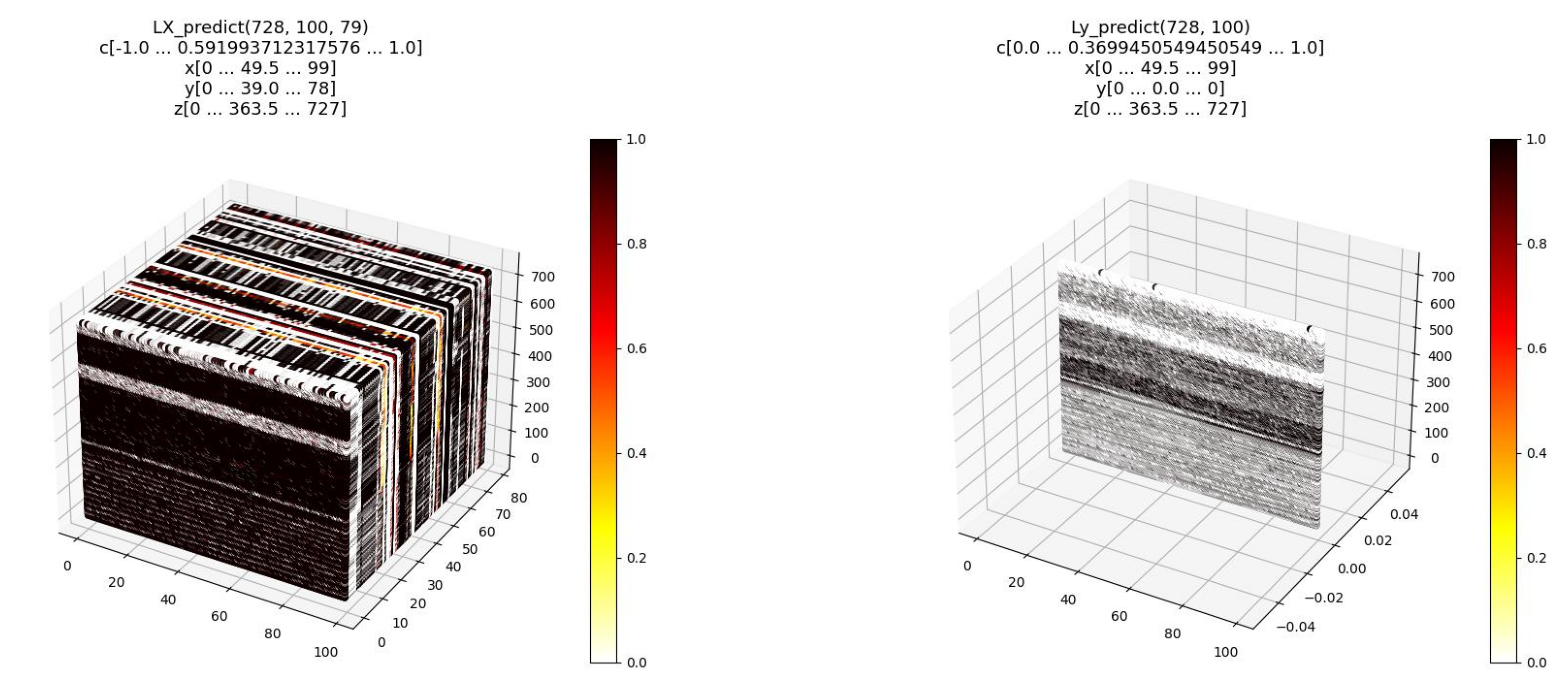

In [14]:
#@title overview featured vs normalized data IMG

show_4d_imgs(['LX_predict','Ly_predict'])

# 4.INTRODUCTION

# 5.LSTM Anomaly State management

## 5.1.Model layers



In [15]:
# threshold(num) là ngưỡng quyết định kết quả dữ đoán là anomaly hay benign, ví dụ: 0.5 ở đây là
# nếu kết quả dự đoán > 0.5 thì xem là anomaly, còn lại là benign, kết quả dự đoán của 1 flow
def threshold(num):
    return 1 if num > 0.5 else 0

def infer_by_checkpoint(checkpoint, name='model6'):
    model = keras.models.load_model(f"/usr/local/opnsense/scripts/ml/aicheckpoints/{checkpoint}/{name}")
    Ly_predict_predicted=model.predict(LX_predict)
    predicted = np.vectorize(threshold)(Ly_predict_predicted)
    
    actual = predicted.ravel()
    expected = Ly_predict.ravel()
    anomaly_detected = anomaly_incorrect = benign_detected = benign_incorrect = 0
    for i in range(0, len(actual)):
        anomaly_detected += actual[i] == expected[i] == 1
        anomaly_incorrect += (actual[i] == 0) & (expected[i] == 1)
        benign_detected += actual[i] == expected[i] == 0
        benign_incorrect += (actual[i] == 1) & (expected[i] == 0)
    
    df = DataFrame.from_dict({
        'checkpoint': [checkpoint],
        'anomaly_detected': [anomaly_detected],
        'anomaly_incorrect': [anomaly_incorrect],
        'benign_detected': [benign_detected],
        'benign_incorrect': [benign_incorrect],
        'detected': [anomaly_detected + benign_detected],
        'incorrect': [anomaly_incorrect + benign_incorrect],
        'detected_rate': [(anomaly_detected + benign_detected) / len(actual)],
        'incorrect_rate': [(anomaly_incorrect + benign_incorrect) / len(actual)],
    })    
    print(df.to_string())

    [IMG['Ly_predict_predicted']] = ray.get([
        show_scattered_4d.remote(Ly_predict_predicted, "Ly_predict_predicted"),
    ])
    show_4d_imgs(['LX_predict','Ly_predict','Ly_predict_predicted'])
    
    return df

___

# 6.LSTM Anomaly model (Primary)

## 6.3.Infer



2023-03-18 08:59:44.768022: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-03-18 08:59:44.768799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-03-18 08:59:44.769511: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capability: 8.6
2023-03-18 08:59:44.770250: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 13348 MB memory:  -> device: 3, name: NVIDIA A16, pci bus id: 0000:42:00.0, compute capability: 8.6


  checkpoint  anomaly_detected  anomaly_incorrect  benign_detected  benign_incorrect  detected  incorrect  detected_rate  incorrect_rate
0  2023W1108             26926                  6            45864                 4     72790         10       0.999863        0.000137


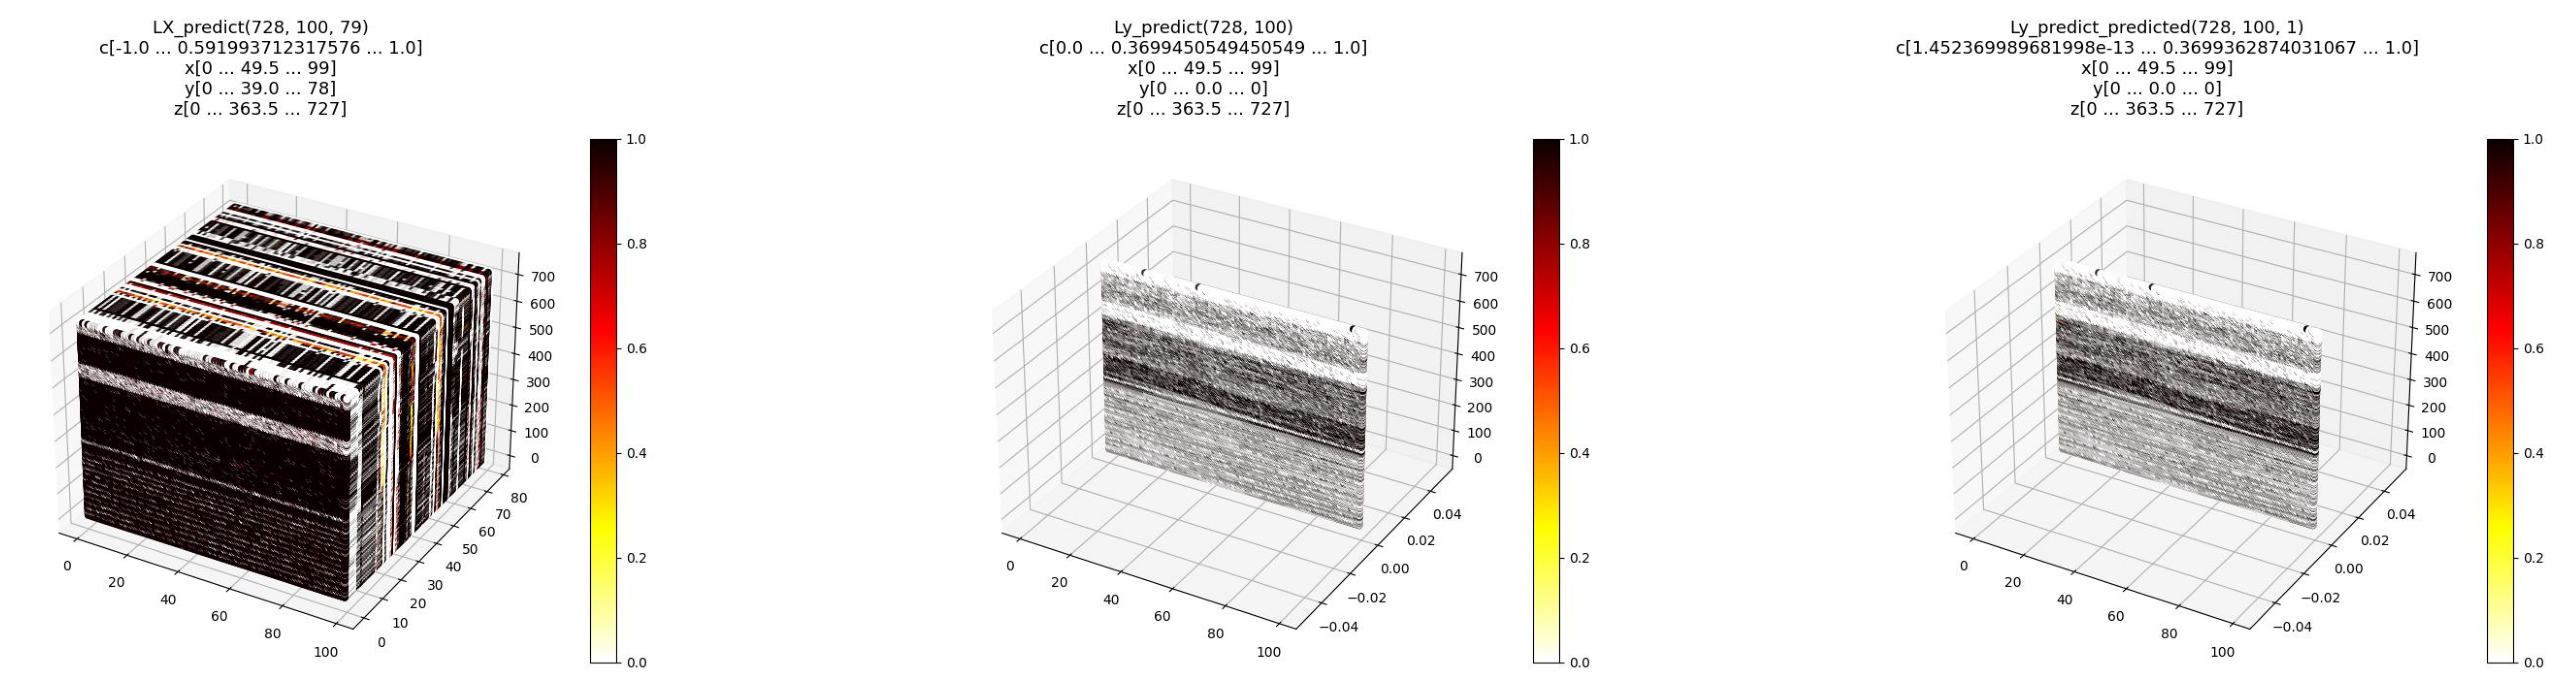

  checkpoint  anomaly_detected  anomaly_incorrect  benign_detected  benign_incorrect  detected  incorrect  detected_rate  incorrect_rate
0  2023W1107             10270              16662            38032              7836     48302      24498       0.663489        0.336511


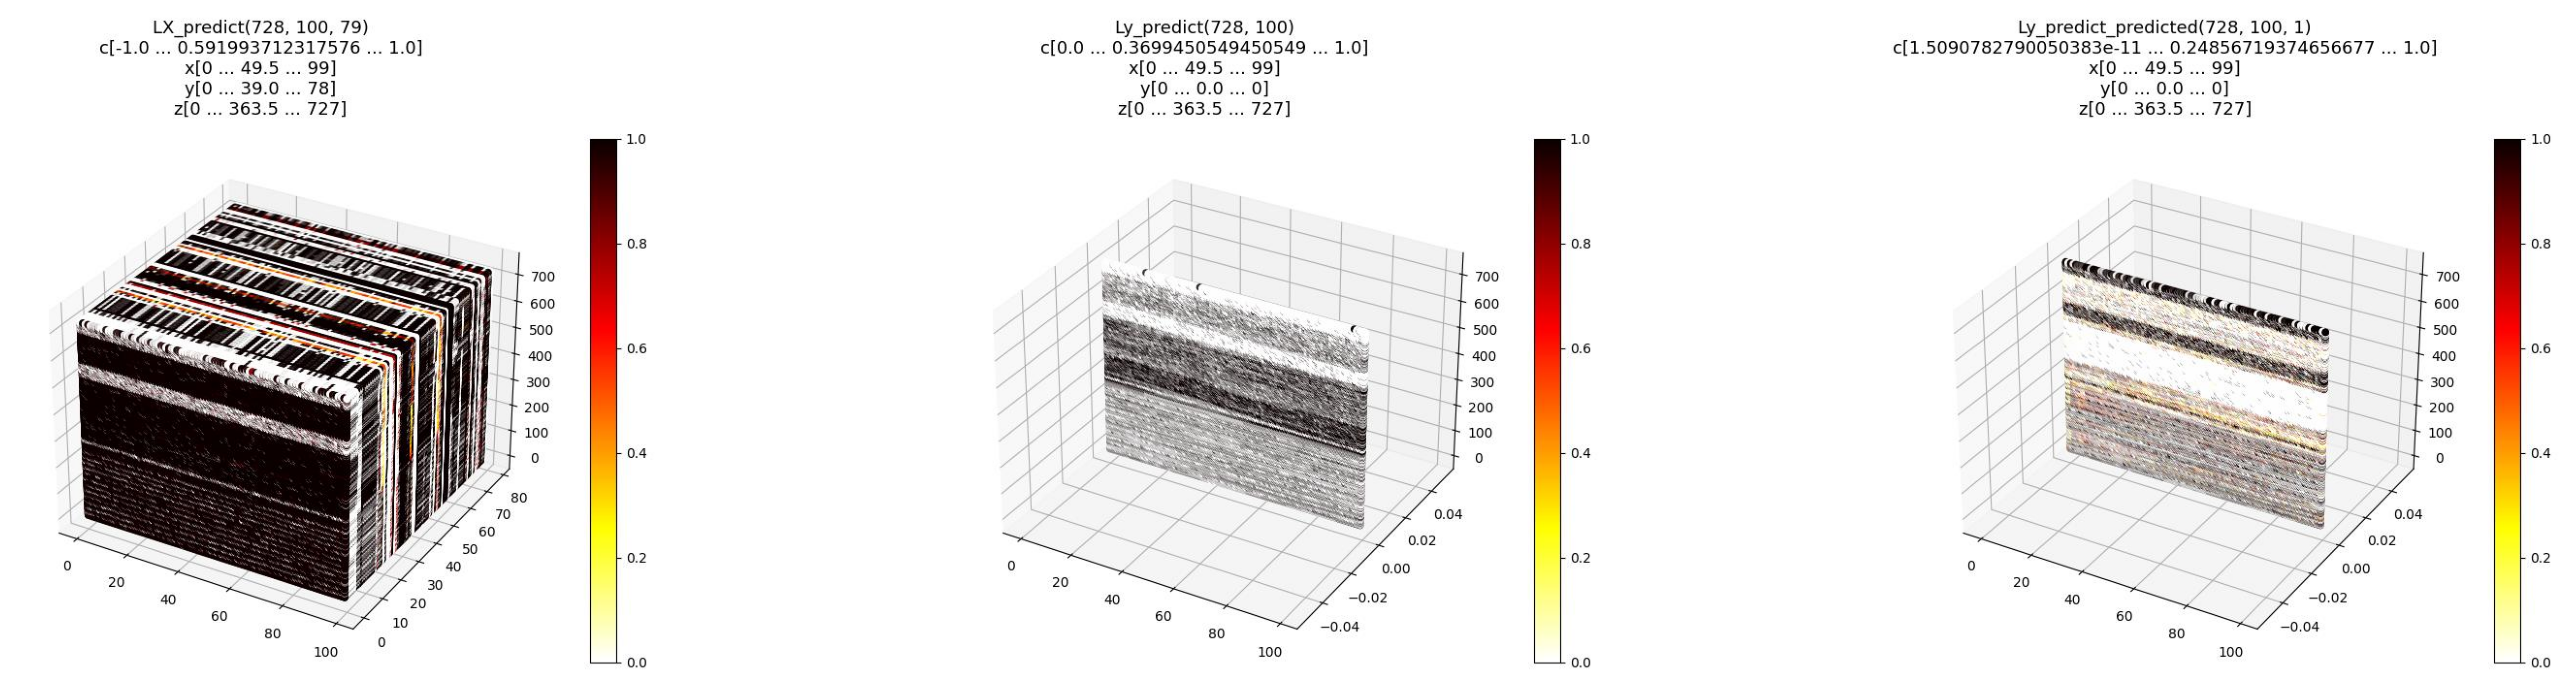

  checkpoint  anomaly_detected  anomaly_incorrect  benign_detected  benign_incorrect  detected  incorrect  detected_rate  incorrect_rate
0  2023W1106             13264              13668            38796              7072     52060      20740        0.71511         0.28489


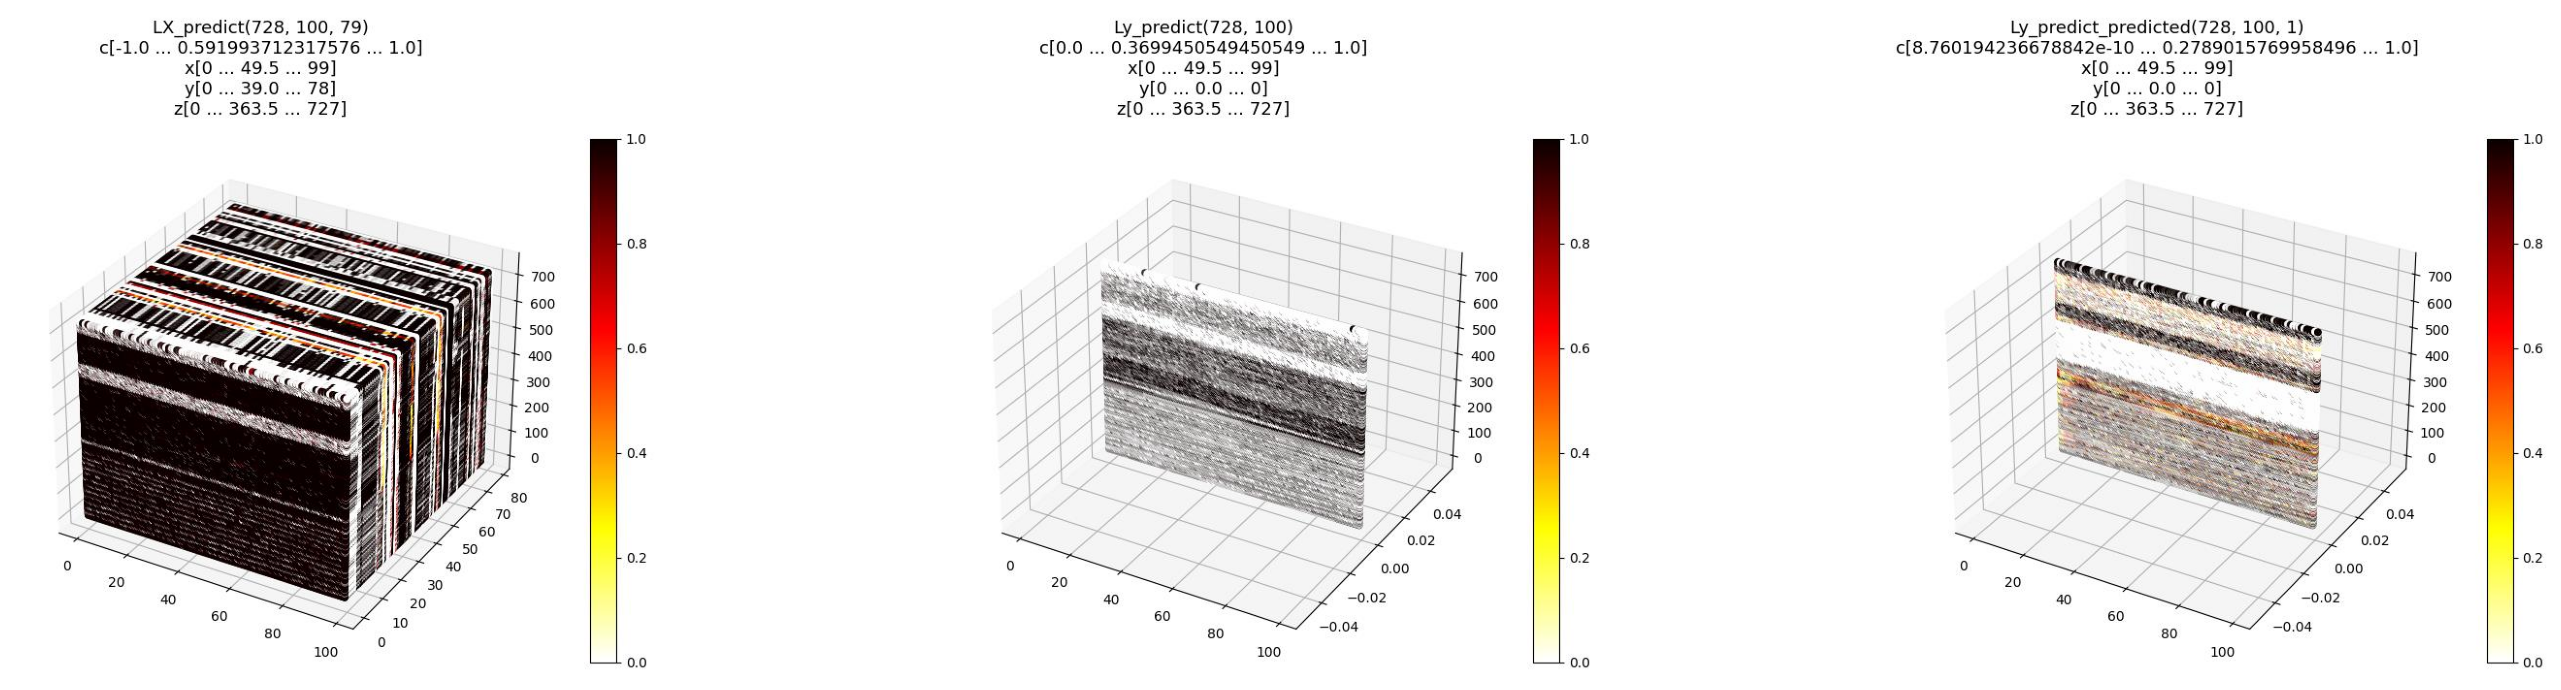

  checkpoint  anomaly_detected  anomaly_incorrect  benign_detected  benign_incorrect  detected  incorrect  detected_rate  incorrect_rate
0  2023W0904             26551                381            45259               609     71810        990       0.986401        0.013599


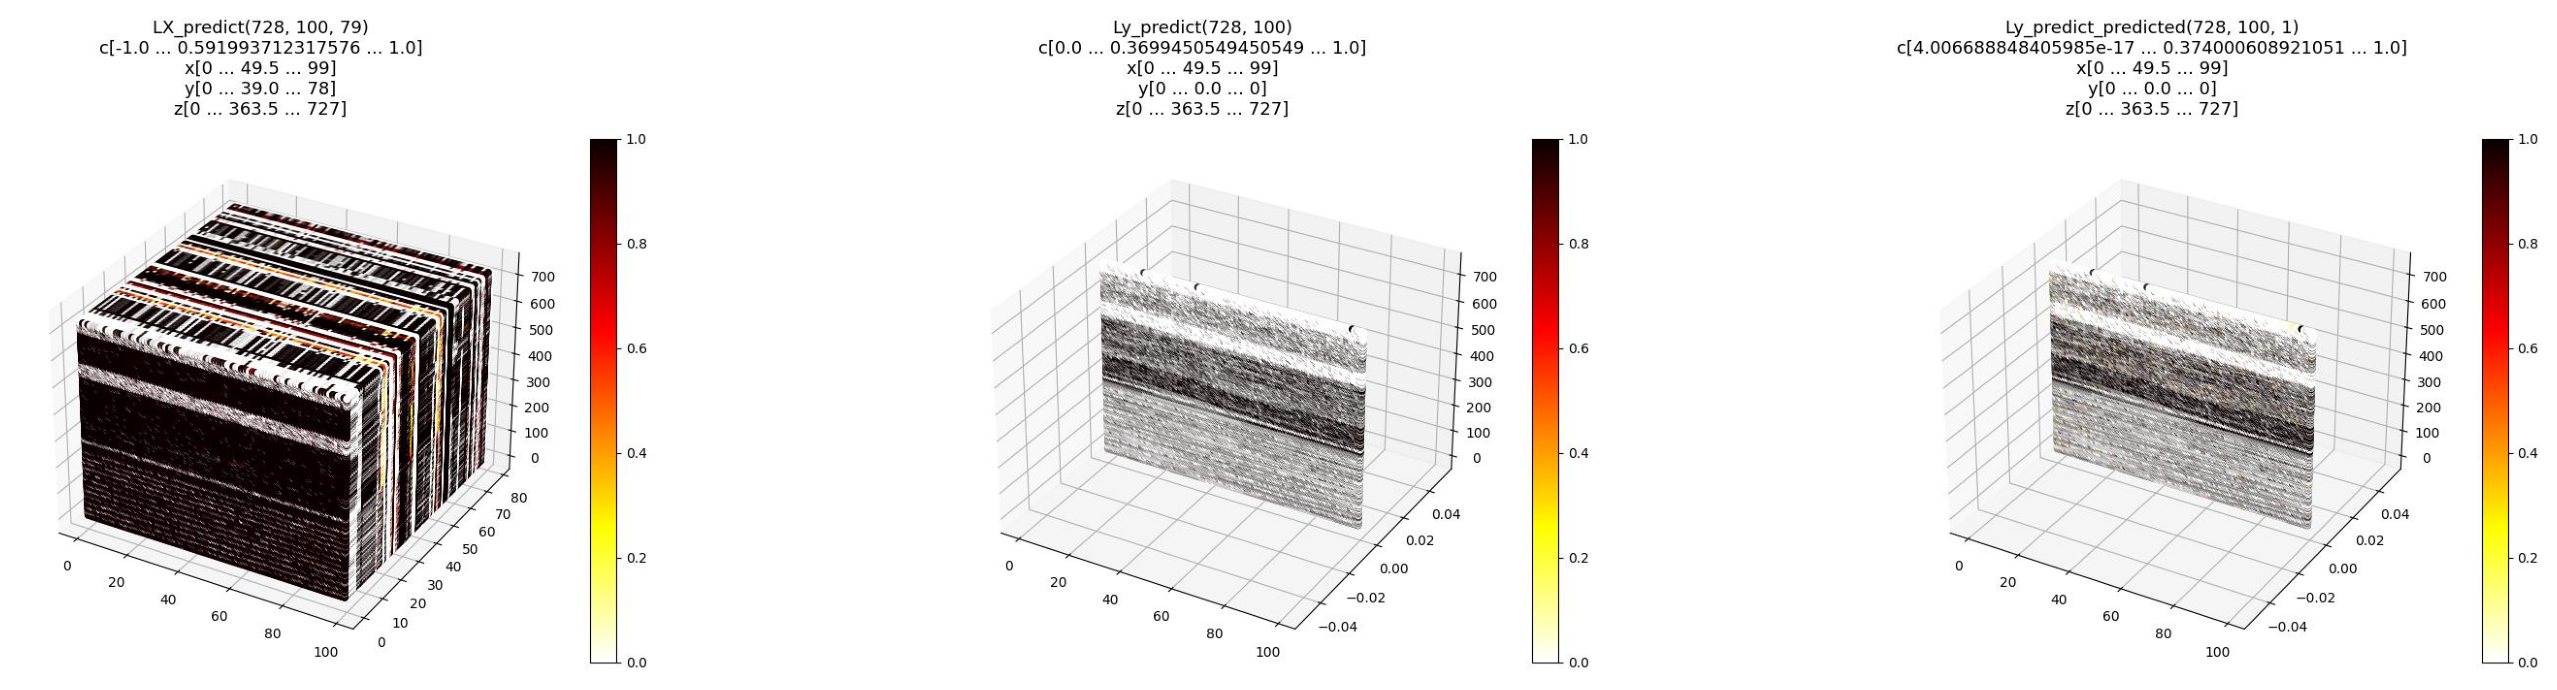

checkpoint  anomaly_detected  anomaly_incorrect  benign_detected  \
0  2023W1108             26926                  6            45864   
1  2023W1107             10270              16662            38032   
2  2023W1106             13264              13668            38796   
3  2023W0904             26551                381            45259   

   benign_incorrect  detected  incorrect  detected_rate  incorrect_rate  
0                 4     72790         10       0.999863        0.000137  
1              7836     48302      24498       0.663489        0.336511  
2              7072     52060      20740       0.715110        0.284890  
3               609     71810        990       0.986401        0.013599

In [16]:
df = DataFrame()
for c in checkpoints:
    dfc = infer_by_checkpoint(c)
    df = pd.concat([df, dfc], axis=0, ignore_index=True)
df